In [1]:
import os
import sys
import math
import time
import argparse
import numpy as np

from PIL import Image

from datetime import datetime

import dataGenerator

import torch
import torch.utils
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

import torchvision
import torchvision.utils as vutils
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

from livelossplot import PlotLosses

# Define DataLoader

In [2]:
# default values
NUM_CLASSES = 1
EPOCHS = 1500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batchSize = 3
iteration = "1"
newTraining = False
imageSize = 416
cwd = os.getcwd()
SAVE_LOCATION = cwd + "/data/models/model_test"
LOAD_LOCATION = cwd + "/data/models/model_test"
INTERRUPTED_LOCATION = cwd + "/data/models/model_interrupted"
#data_dir = cwd + "/data/photos/"
data_dir = "./data/"

from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Load Data

In [3]:
data_transforms = transforms.Compose([transforms.Resize([imageSize,imageSize]),
                                      transforms.ToTensor()
                                     ])

# instantiate the dataset and dataloader
dataset = ImageFolderWithPaths(data_dir, transform=data_transforms) # our custom dataset

#loads only photos
dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle=True)

new_road_factory = dataGenerator.dataGenerator(IMAGE_SIZE=imageSize)

# Training W/O Val Steps

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=4):
    since = time.time()
    best_model = None
    best_loss = math.inf
    model.train()  
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch + 1, num_epochs), flush=True)
        epoch_loss = 0
        running_loss = 0.0
        running_corrects = 0
        logs = {}
        
        #BATCH TUPLE
        inputs, labels, paths = next(iter(dataloaders))
        inputs.to(device)
        #labels.to(device)
        
        # Moved outside paths forloop as labels would be reset
        i = 0
        labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize).to(device)
        
        #build ground-truth batch tensor
        for locations in paths:
            #dtype=torch.int64
            ### Why are we using float?
            #labels = torch.zeros(batchSize,NUM_CLASSES,imageSize,imageSize, dtype = torch.float32).to(device)
            loc = locations.replace(".png", ".pt").replace("photos", "tensors")
            labels[i] = torch.load(loc)
            #print("loading tensor:", i,  loc, flush=True)
            #print("tensor max:", torch.max(labels[i]))
            i += 1
            
        # forward
        
        with torch.set_grad_enabled(True):
            #build input-truth batch tensor
            outputs = model(inputs.to(device)).to(device)
            #outputs = model(inputs)
            loss = criterion(outputs, labels) #ground truth comparison

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # backward + optimize 
            loss.backward()
            optimizer.step()
            
            # statistics
            epoch_loss += loss.item()
        
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * inputs.size(0)
        #running_corrects += torch.sum(preds == labels.data, dtype = torch.float32)
        labels = labels.to(dtype=torch.long)
        running_corrects += torch.sum(preds == labels.data)
        
        e_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

#         print("loss: {}".format(epoch_loss), flush=True)
#         print("Running corrects: {}".format(running_corrects), flush=True)
#         print('---------------', flush=True)
        
        logs['log loss'] = epoch_loss
        #logs['accuracy'] = epoch_acc
        logs['accuracy'] = 1 - epoch_loss
        
        liveloss.update(logs)
        liveloss.draw()
        
        #save best copy of  model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), SAVE_LOCATION.replace("test", "best"))
            torch.save(model.state_dict(), SAVE_LOCATION.replace("test", "best") + "-" + str(datetime.now().date()))
            #torch.save(model, SAVE_LOCATION)
            #torch.save(model, SAVE_LOCATION.replace("model", "model_best"))
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.1f}m {:.1f}s'.format(time_elapsed // 60, time_elapsed % 60), flush=True)

    #completed model
    torch.save(model,SAVE_LOCATION)
    return model

# Load Pretrained Model Weights

In [5]:
from unet_models import *

#imports related to UNet
if newTraining:
    model = UNet16(num_classes=1, num_filters=32, pretrained=False, is_deconv=True)
    
    print('initializing model with random weights', flush=True)
    torch.nn.init.xavier_uniform_(next(model.center.children())[1].weight)
    
    torch.nn.init.xavier_uniform_(next(model.dec5.children())[1].weight)
    
    torch.nn.init.xavier_uniform_(next(model.dec4.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec3.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec2.children())[1].weight)

    torch.nn.init.xavier_uniform_(next(model.dec1.children()).weight)

    torch.nn.init.xavier_uniform_(model.final.weight)
                           
else:
    print("loading weights from", LOAD_LOCATION, flush=True)
    #model = torch.load(SAVE_LOCATION)
    model = torch.load(LOAD_LOCATION)
    

criterion = torch.nn.BCEWithLogitsLoss()
#criterion = DICELossMultiClass()
#criterion = IOU_BCELoss()

#Observe adjustments in learning rate
optimizer_ft = optim.Adam(model.parameters(), lr=0.05,weight_decay=0, amsgrad=False, eps=0.1)

# Osscilate between high and low learning rates over time
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=EPOCHS,eta_min=0.001)  


#model = model.to(device)

loading weights from /home/royce/workspace/research/COMP-596/data/models/model_test


# Training and Results

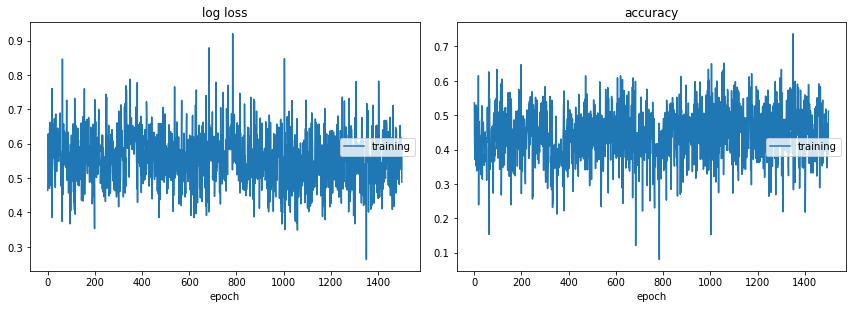

log loss:
training   (min:    0.263, max:    0.920, cur:    0.488)

accuracy:
training   (min:    0.080, max:    0.737, cur:    0.512)
Training complete in 132.0m 50.0s


In [8]:
try:
    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=EPOCHS)

except KeyboardInterrupt:
    torch.save(model, INTERRUPTED_LOCATION)
    print('Saved interrupt', flush=True)

In [10]:
# for tensor in labels:
#     #tensor = labels[0]
#     tensor_max_value = torch.max(tensor)
#     print(tensor_max_value)
#     print(type(tensor_max_value.item()))
    

tensor(1., device='cuda:0')
<class 'float'>
tensor(1., device='cuda:0')
<class 'float'>
tensor(1., device='cuda:0')
<class 'float'>
